### Modules

In [ ]:
import itertools
import random, math, os

import numpy as np
import PIL
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

from google.colab import drive

### Mount

In [ ]:
drive.mount('/content/gdrive')

### Global Variables

In [ ]:
CLASSES = ['Hyundai ix35', 'Toyota Corolla', 'Renault Megane', 'Audi S6', 'BMW X5', 'Peugeot 5008', 'Mazda 6', 'Chrysler Pacifica', 'Ford Edge', 'Mitsubishi Outlander']
SRC_FOLDER = '/content/gdrive/MyDrive/Colab Notebooks/tasarım/images'
IMAGE_FOLDER  = '/content/images'
DATASET_FOLDER = '/content/dataset'

SRC_PATH = [os.path.join(SRC_FOLDER, filename) for filename in os.listdir(SRC_FOLDER)]
IMAGE_PATH = [os.path.join(IMAGE_FOLDER, filename) for filename in os.listdir(SRC_FOLDER)]

Mounted at /content/gdrive


### Plot Function

In [ ]:
def plot_samples(orig_image, transform, sample_count=4, **kwargs):
  images = [orig_image] + [transform(orig_image) for i in range(sample_count)]
  num_cols = len(images)
  fig, axes = plt.subplots(nrows=1, ncols=num_cols, **kwargs)

  for col_idx, img in enumerate(images):
    ax = axes[col_idx]
    ax.imshow(np.asarray(img), cmap='gray')
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  axes[0].set(title='Original Image')
  axes[0].title.set_size(10)
  plt.tight_layout()

In [ ]:
orig_img = PIL.Image.open(SRC_PATH[0])
orig_img = PIL.ImageOps.grayscale(orig_img)

### Brand Remover

In [ ]:
class BrandRemover(object):
  def __init__(self):
    self.transform_1 = T.ToTensor()
    self.transform_2 = T.ToPILImage()

  def __call__(self, pic):
    pic = self.transform_1(pic)
    pic[(0.5 > pic) & (pic > 0.3)] = 0.1
    pic[(0.9 > pic) & (pic > 0.7)] = 0.9
    pic = self.transform_2(pic)
    return pic

  def __repr__(self):
    return self.__class__.__name__ + '()'

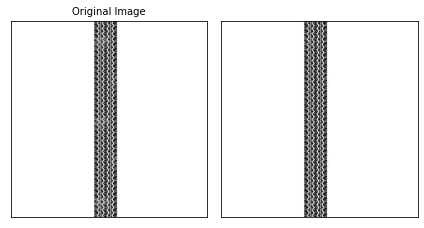

In [ ]:
plot_samples(orig_img, BrandRemover(), 1)

In [ ]:
brand_remover = BrandRemover()

if not os.path.exists(IMAGE_FOLDER):
  os.mkdir(IMAGE_FOLDER)

for path in SRC_PATH:
  filename = os.path.split(path)[-1]
  image = PIL.Image.open(path)
  image = PIL.ImageOps.grayscale(image)
  image = brand_remover(image)
  image.save(os.path.join(IMAGE_FOLDER, filename))

### Transform Classes

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        tensor = tensor + torch.randn(tensor.size()) * self.std + self.mean
        tensor[tensor > 1.0] = 1.0
        tensor[tensor < 0] = 0.0
        return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
class AddPerlinNoise(object):
  def __init__(self, factor=1.0, res=10, mean=0.0):
    self.factor = factor
    self.res = res
    self.mean = mean

  def __call__(self, tensor):
    tensor = tensor + self.perlin(tensor.shape)
    tensor[tensor > 1.0] = 1.0
    tensor[tensor < 0] = 0.0
    return tensor

  def __repr__(self):
    return self.__class__.__name__ + '(factor={0}, res={1}, mean={2})'.format(self.factor, self.res, self.mean)

  def perlin(self, shape):
    lin_x = np.linspace(0, self.res, shape[-1], endpoint=False)
    lin_y = np.linspace(0, self.res, shape[-2], endpoint=False)
    x, y = np.meshgrid(lin_x, lin_y)

    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()

    xi = x.astype(int)
    yi = y.astype(int)
    
    xf = x - xi
    yf = y - yi

    lerp = lambda a, b, x: a + x * (b - a)
    fade = lambda t: 6 * t**5 - 15 * t**4 + 10 * t**3
    
    u = fade(xf)
    v = fade(yf)
    
    n00 = self.gradient(p[p[xi] + yi], xf, yf)
    n01 = self.gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = self.gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = self.gradient(p[p[xi + 1] + yi], xf - 1, yf)
    
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u)

    return (torch.from_numpy(lerp(x1,x2,v)) + self.mean) * self.factor

  def gradient(self, h, x, y):
      vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
      g = vectors[h%4]
      return g[:,:,0] * x + g[:,:,1] * y

In [ ]:
class Deforme(object):
  def __init__(self, rc, tc):
    self.rc = rc 
    self.tc = tc

  def __call__(self, tensor):
    deformed = torch.ones_like(tensor)

    C, H, W = tensor.shape

    state = random.randint(0, 1)

    if(state == 0): orig_x, orig_y = (W // 4), (H // 2)
    if(state == 1): orig_x, orig_y = (3*W // 4), (H // 2)

    rc = 2 * self.rc * random.random() - self.rc
    tc = 2 * self.tc * random.random() - self.tc
    
    for x1, y1 in itertools.product(range(H), range(W)):
        x2 = x1 - orig_x
        y2 = y1 - orig_y

        r = math.sqrt(x2*x2 + y2*y2)
        theta = math.atan(y2 / (x2 + 0.001))

        r = r + rc
        theta = theta + tc

        if x2 < 0:
          theta = theta + 3.14

        x2 = math.floor(r * math.cos(theta))
        y2 = math.floor(r * math.sin(theta))

        x2 = x2 + orig_x
        y2 = y2 + orig_y

        if (0 <= x2 < W) and (0 <= y2 < H):
          deformed[:, y1, x1] = tensor[:, y2, x2]

    return deformed
    
  def __repr__(self):
        return self.__class__.__name__ + '(rc={0}, tc={1})'.format(self.rc, self.tc)

### Generator Classes

In [ ]:
class ImageGenerator(object):
  def __init__(self, filepath, transform):
    self.image = PIL.Image.open(filepath)
    self.image = PIL.ImageOps.grayscale(self.image)
    self.transform = transform

  def __next__(self):
    return self.transform(self.image)

  def __repr__(self):
    return self.__class__.__name__ + '(filename={0}, transform={1})'.format(self.filename, self.transform)

In [ ]:
class ComplexImageGenerator(object):
  def __init__(self, filepaths, transform):
    self.images = [PIL.Image.open(fp) for fp in filepaths]
    self.images = [PIL.ImageOps.grayscale(img) for img in self.images]
    self.transform = transform

    self.pre_transform_1 = T.RandomRotation((30, 60), fill=255)
    self.pre_transform_2 = T.RandomRotation((-60, -30), fill=255)
    self.pre_transform_3 = T.ToTensor()
    self.pre_transform_4 = T.ToPILImage()

  def __next__(self):
    image_1 = random.choice(self.images)
    image_2 = random.choice(self.images)

    image_1 = self.pre_transform_1(image_1)
    image_2 = self.pre_transform_2(image_2)

    image_3 = 0.5 * self.pre_transform_3(image_1) + 0.5 * self.pre_transform_3(image_2)
    image_3[image_3 > 1.0] = 1.0
    image_3[image_3 < 0.6] = 0.1
    image_3 = self.pre_transform_4(image_3)
    
    return self.transform(image_3)

  def __repr__(self):
    return self.__class__.__name__ + '(filename={0}, transform={1})'.format(self.filename, self.transform)

### Transform Sequence

In [ ]:
transform = T.Compose([
  T.ToTensor(),
  Deforme(80.0, 0.4),
  T.RandomAffine(degrees=(0, 180), translate=(0.2, 0.0), fill=1.0),
  AddPerlinNoise(factor=1.0, res=5, mean=0.5),
  AddGaussianNoise(std=0.1),
  T.CenterCrop((640, 640)),
  T.ToPILImage(),
])

transform_1 = T.Compose([
  T.ToTensor(),
  AddPerlinNoise(factor=1.0, res=5, mean=0.5),
  T.CenterCrop((640, 640)),
  T.ToPILImage(),
])

transform_2 = T.Compose([
  T.ToTensor(),
  AddGaussianNoise(std=0.1),
  T.CenterCrop((640, 640)),
  T.ToPILImage(),
])

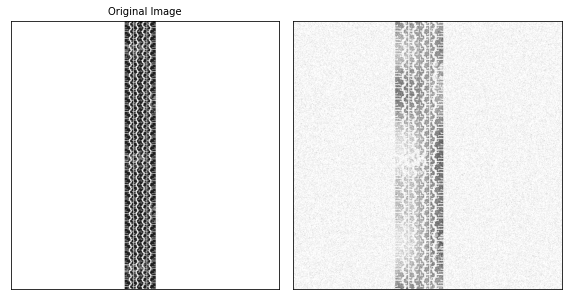

In [ ]:
plot_samples(orig_img, transform, 1, figsize=(8, 8))

### Create an Image Generator

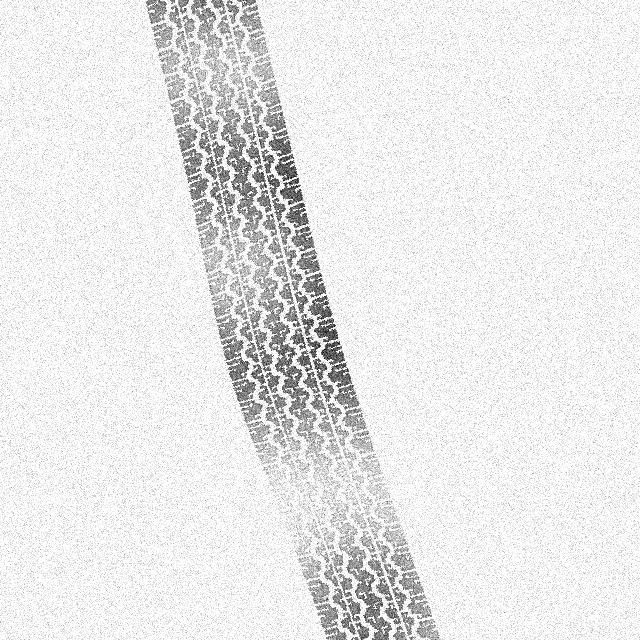

In [ ]:
gen = ImageGenerator(IMAGE_PATH[0], transform)
next(gen)

### Create the Dataset

In [ ]:
image_per_class = 100

if not os.path.exists(DATASET_FOLDER):
  os.makedirs(DATASET_FOLDER)

for cls in CLASSES:
  dir = os.path.join(DATASET_FOLDER, cls)
  
  if not os.path.exists(dir):
    os.makedirs(dir)
  
  gen = ImageGenerator(f'{IMAGE_FOLDER}/{cls}', transform) 

  for i in range(image_per_class):
    image = next(gen)
    imagepath = os.path.join(dir, 'image{0}.jpg'.format(i))
    image.save(imagepath)

### Complex Image Generation

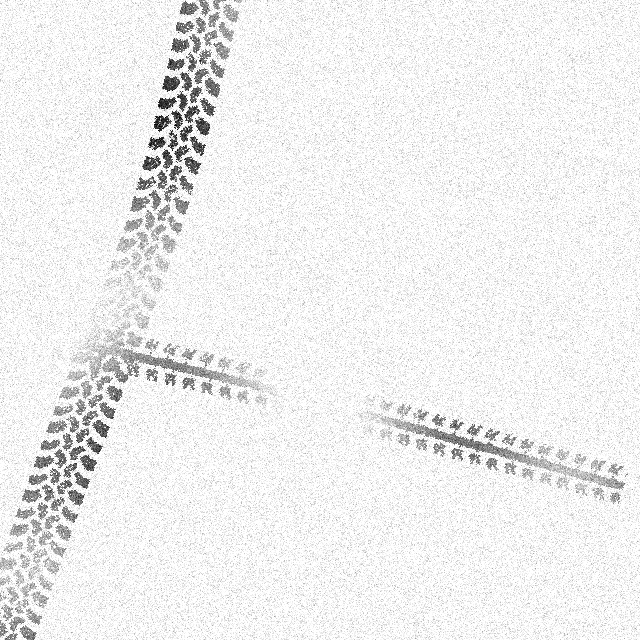

In [ ]:
gen = ComplexImageGenerator(
    filepaths=IMAGE_PATH,
    transform=transform)

next(gen)

In [ ]:
image_count = 2
dir = os.path.join(DATASET_FOLDER, 'complex')

if not os.path.exists(dir):
  os.makedirs(dir)

for i in range(image_count):
  image = next(gen)
  imagepath = os.path.join(dir, 'image{0}.jpg'.format(i))
  image.save(imagepath)

In [ ]:
!zip -r data.zip dataset

  adding: dataset/ (stored 0%)
  adding: dataset/complex/ (stored 0%)
  adding: dataset/complex/image0.jpg (deflated 0%)
  adding: dataset/complex/image1.jpg (deflated 1%)
